# Rain Reports
Initial Development. <br>

TODO List: 
* Add more info in the tabular side of the report -> ok
* Make the report with the anomalies
* Refactor the code
* Rewrite the tests
* Write console activation
* Separate downloader from reporter
* Automate report generation for several basins at once
* Add reference layer -> ok

In [22]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from raindownloader.parser import BaseParser
from raindownloader.inpeparser import INPE, INPEParsers, INPETypes
from raindownloader.downloader import Downloader
from raindownloader.utils import FileType, DateProcessor, DateFrequency
from rainreporter.reporter import RainReporter

import rasterio as rio
import xarray as xr
from raindownloader.utils import GISUtil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing Monthly Accumulated Parser

In [23]:
downloader = Downloader(
    server=INPE.FTPurl,
    parsers=INPEParsers.parsers,
    post_processors=INPEParsers.post_processors
)


In [24]:
files = downloader.get_range('20230101', '2023-12', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACCUM)

In [25]:
files

[PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_jan.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_feb.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_mar.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_apr.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_may.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_jun.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_jul.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_aug.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_sep.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_oct.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_nov.nc'),
 PosixPath('../tmp/MONTHLY_ACCUM/MERGE_CPTEC_acum_dec.nc')]

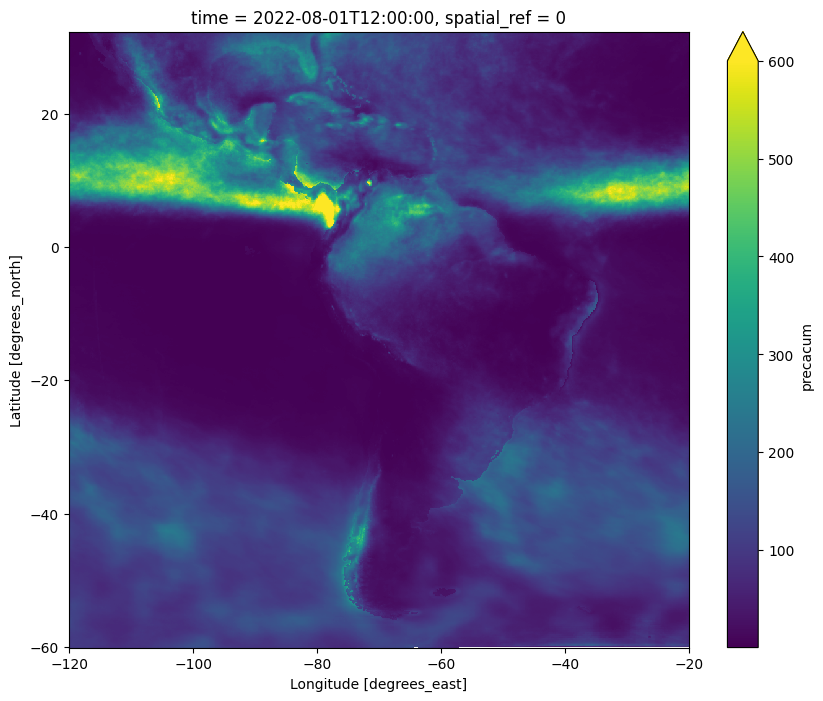

In [26]:
file = downloader.download_file('2023-08', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACCUM)
ma = downloader.open_file(file)[INPETypes.MONTHLY_ACCUM.value]
ma.plot(figsize=(10, 8), vmax=600)

In [27]:
file = downloader.download_file('20230101', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACCUM_YEARLY)
may = downloader.open_file(file)[INPETypes.MONTHLY_ACCUM_YEARLY.value]

In [28]:
file = downloader.download_file('20230101', local_folder='../tmp', datatype=INPETypes.DAILY_AVERAGE)
daily_average = downloader.open_file(file)[INPETypes.DAILY_AVERAGE.value]

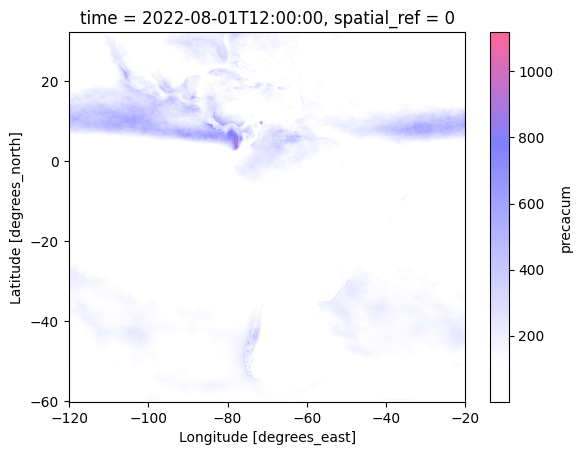

In [29]:
ma.plot(cmap=INPE.cmap)

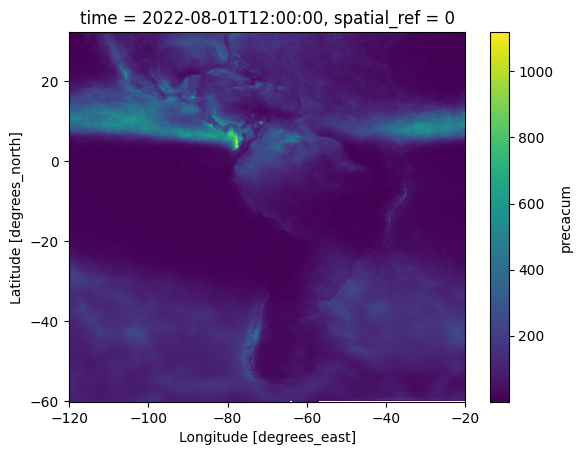

In [30]:
ma.plot()

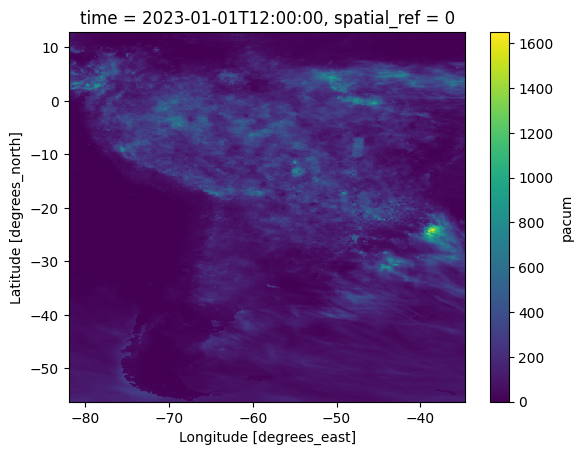

In [31]:
may.plot()

In [32]:
may.rio.crs

CRS.from_epsg(4326)

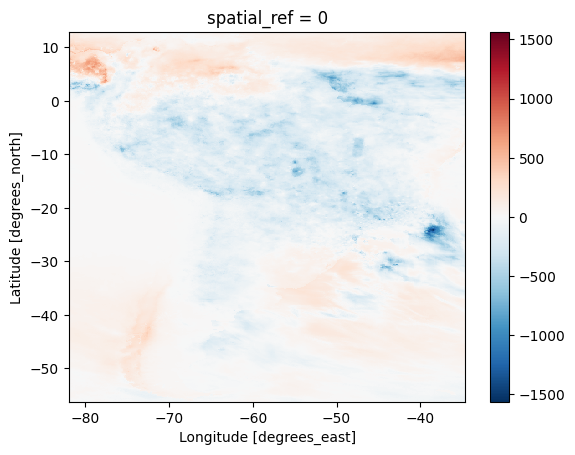

In [33]:
(ma.squeeze() - may.squeeze()).plot()

## Create Anomaly Report

In [34]:
month = 1
year = 2023
lookback = 6

In [35]:
reporter = RainReporter(
    server=INPE.FTPurl,
    download_folder='../tmp',
    post_processors=INPEParsers.post_processors,
    parsers=INPEParsers.parsers
)

In [36]:
paraibuna = gpd.read_file('/workspaces/bases/BaciasIncrementais/SaoFrancisco/Incre_3_Marias_diss_proj.shp')
paraibuna.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
parainuba = paraibuna.set_crs('epsg:3857')

In [38]:
paraibuna.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

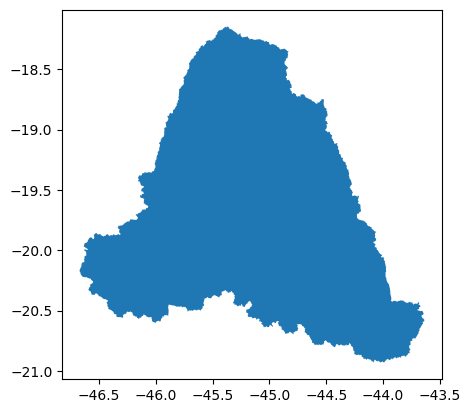

In [39]:
paraibuna.to_crs('epsg:4326').plot()

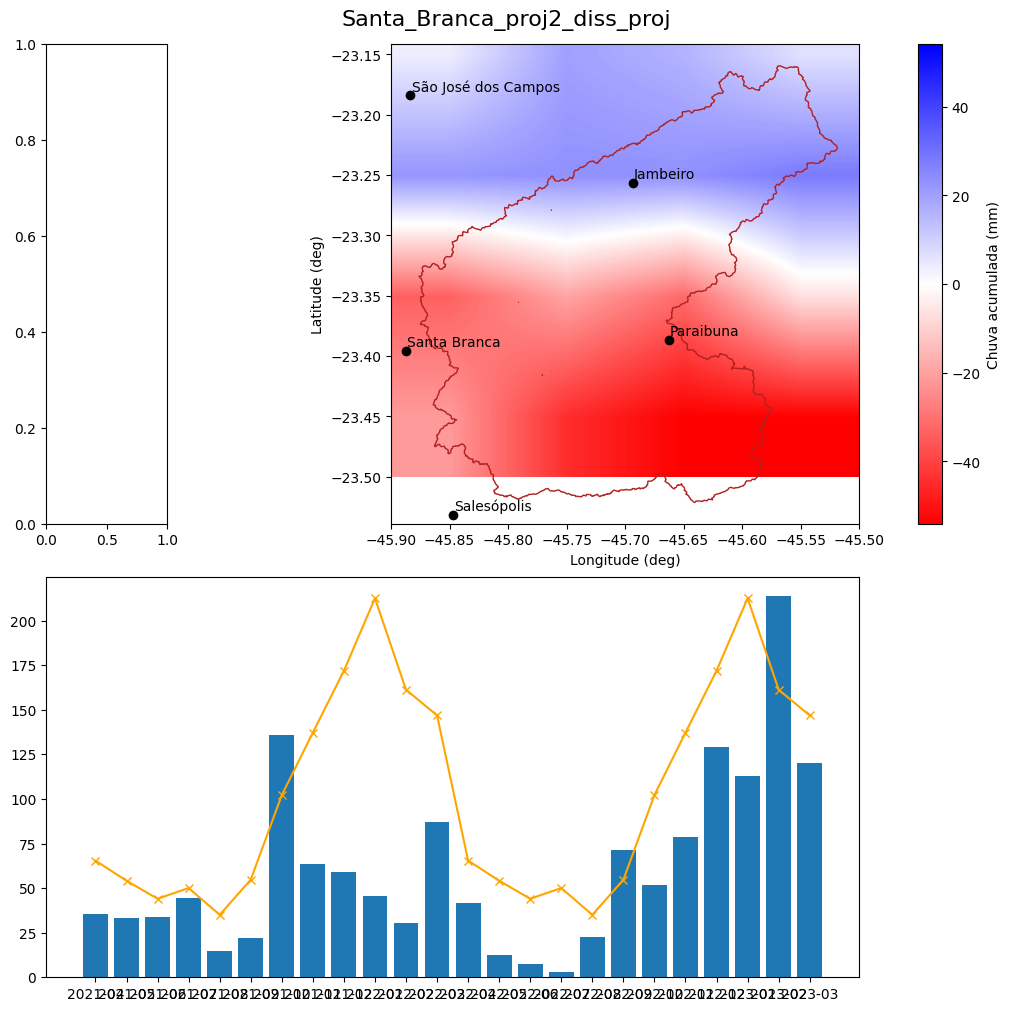

In [43]:
axs, rain, lta, shp = reporter.monthly_anomaly_report(
    date_str='2023-03',
    shapefile='/workspaces/bases/BaciasIncrementais/ParaibaSul/Santa_Branca_proj2_diss_proj.shp',
    month_lbk=24
)

* Pandas
* Numpy


* GeoPandas
* xarray

In [20]:
print(rain.shape)
print(lta.shape)

(24, 924, 1001)
(24, 924, 1001)


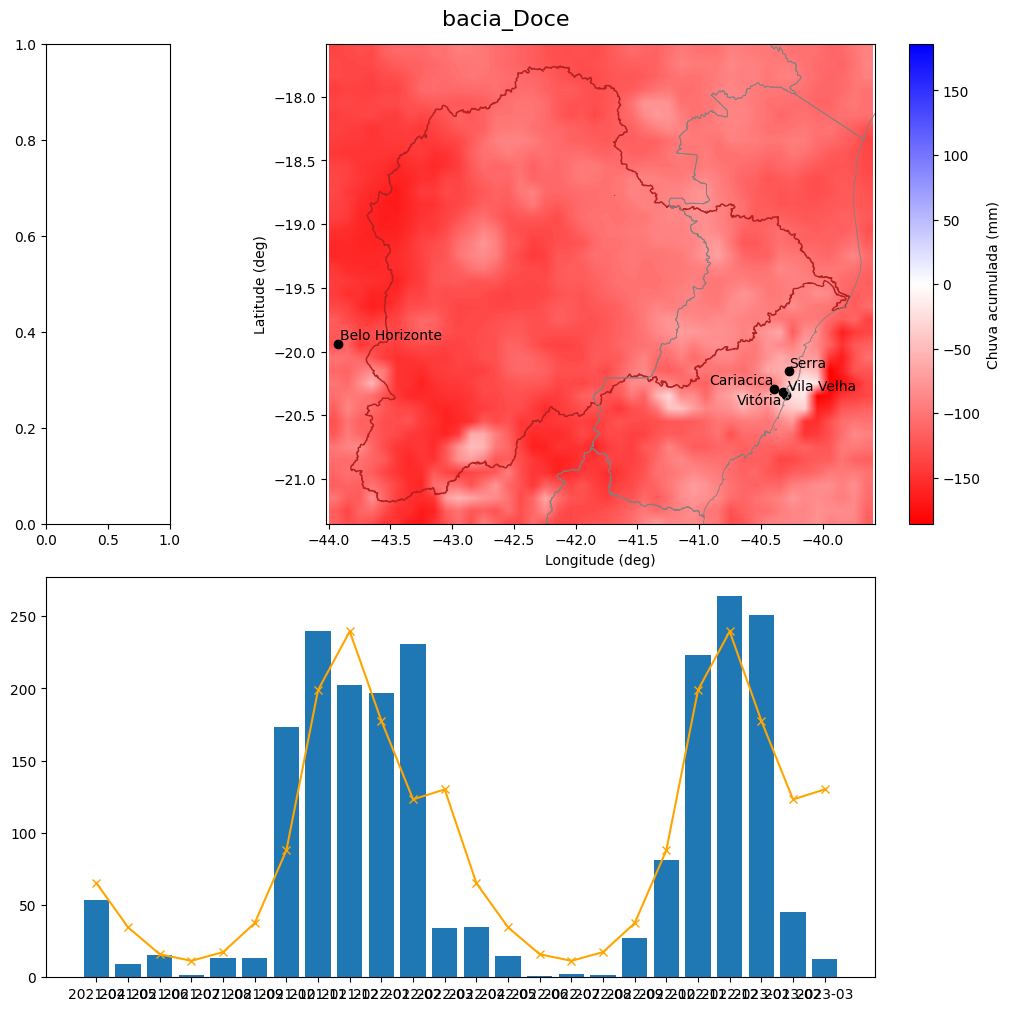

In [21]:
axs, rain, lta, shp = reporter.monthly_anomaly_report(
    date_str='2023-03',
    shapefile='/workspaces/bases/bacias de interesse SOE/bacia_Doce.shp',
    month_lbk=24
)

* Depois: Acumular os valores numéricos dos períodos seco e chuvoso 
* 2 anos de gráfico
* Bacias incrementais
* Incrementais - Reservatórios - Quinzenal???
* Retirar a média de chuva no diário 
* Diário manter os últimos 30 dias
* Chuva anual - 1o Out/30 Sep - Últimos 10 anos
* Furnas ou Serra da Mesa: identificar construções no reservatório 

In [28]:
start_month, end_month = DateProcessor.last_n_months(f'{year}-{month}', lookback)

In [29]:
# Create a cube with the actual rain in the last 6 months
cube = reporter.get_cube(start_month, end_month, datatype=INPETypes.MONTHLY_ACCUM_MANUAL)

### Validate the MANUALY CREATED CUBE


In [84]:
# Create a cube with the actual rain in the last 3 months of 2022 as reference
refcube = reporter.get_cube('2022-10', '2022-12', datatype=INPETypes.MONTHLY_ACCUM_YEARLY)

In [85]:
# cut the cube with the refcube reference
cut_cube = cube.sel({'longitude': refcube.longitude, 'latitude': refcube.latitude}, method='nearest')

In [86]:
cut_cube.mean(dim=['longitude', 'latitude']).values

array([103.96684 , 119.62196 , 115.63491 , 125.79839 , 117.456215,
       128.17114 ], dtype=float32)

In [87]:
refcube.mean(dim=['longitude', 'latitude']).values

array([103.96684, 119.62196, 115.63491], dtype=float32)

###

In [30]:
# Get a basin of interest
shp = gpd.read_file('/workspaces/bases/bacias de interesse SOE/bacia_Sao_Francisco.shp')

In [31]:
# get the time series of the monthly rain
accum_series = RainReporter.get_time_series(
    cube=cube,
    shp=shp,
    reducer=xr.DataArray.mean,
    keep_dim='time'
)

In [32]:
# get the MLT
# the year may not correspond to the year we want because MLT is "yearless"
lta = reporter.get_cube(start_month, end_month, datatype=INPETypes.MONTHLY_ACCUM)
lta_series = RainReporter.get_time_series(
    cube=lta,
    shp=shp,
    reducer=xr.DataArray.mean,
    keep_dim='time'
)

In [42]:
dframe = pd.DataFrame(accum_series)
dframe['lta'] = lta_series.values
dframe

,monthacum,lta
time,,
2022-08-01 12:00:00,6.115089,8.403646
2022-09-01 12:00:00,14.475023,15.464760
2022-10-01 12:00:00,34.251518,53.478138
2022-11-01 12:00:00,211.573914,135.080292
2022-12-01 12:00:00,198.962265,157.650345
2023-01-01 12:00:00,137.223618,141.142212


In [44]:
dframe = dframe.reset_index()
dframe['time'] = dframe['time'].astype('str')
dframe.index = pd.Index(dframe['time'].str[:7])
dframe


,time,monthacum,lta
time,,,
2022-08,2022-08-01 12:00:00,6.115089,8.403646
2022-09,2022-09-01 12:00:00,14.475023,15.464760
2022-10,2022-10-01 12:00:00,34.251518,53.478138
2022-11,2022-11-01 12:00:00,211.573914,135.080292
2022-12,2022-12-01 12:00:00,198.962265,157.650345
2023-01,2023-01-01 12:00:00,137.223618,141.142212


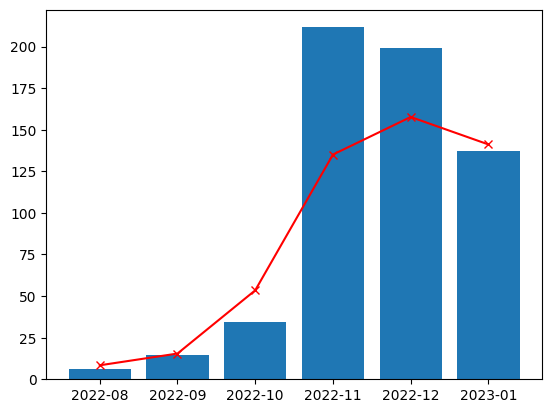

In [90]:
_, ax = plt.subplots()
ax.bar(dframe.index, dframe['monthacum'])
ax.plot(dframe.index, dframe['lta'], color='red', marker='x')


In [91]:
# before creating the anomaly map, let's make sure we are comparing the same months
last_rain_dt = cube.time[-1].values
last_lta_dt = lta.time[-1].values

assert pd.to_datetime(last_rain_dt).month == pd.to_datetime(last_lta_dt).month

# create the anomaly map
last_rain = cube.sel(time=last_rain_dt)
last_lta = lta.sel(time=last_lta_dt)

In [92]:
# subtract them
anomaly = last_rain.copy()
anomaly.data = last_rain.data - last_lta.data

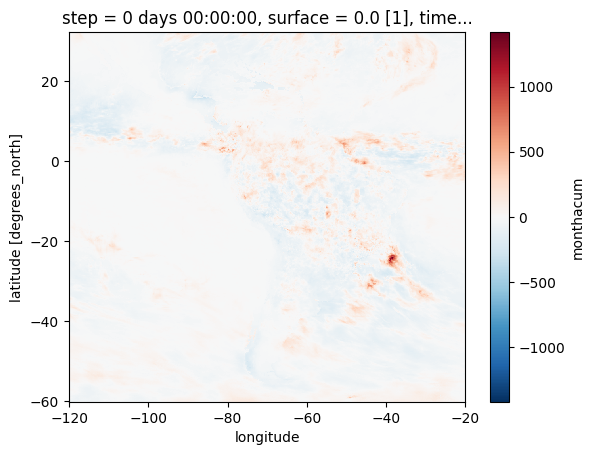

In [94]:
anomaly.plot()

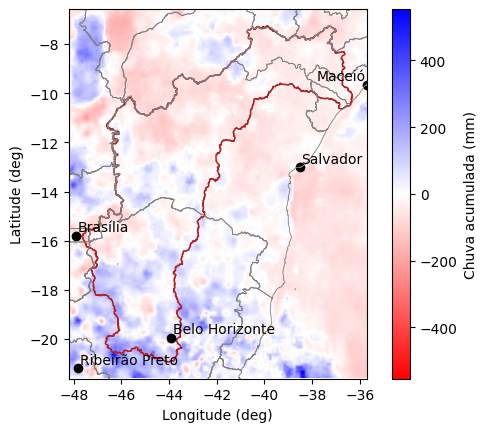

In [111]:
_,ax = plt.subplots()

reporter.plot_anomaly_map('2023-01', shp, ax)
reporter.plot_cities(plt_ax=ax)
reporter.plot_states(plt_ax=ax)

In [106]:
# create the anomaly raster
anomaly = rain.copy()
anomaly.data = rain.data - lta.data

In [ ]:
rain.plot()

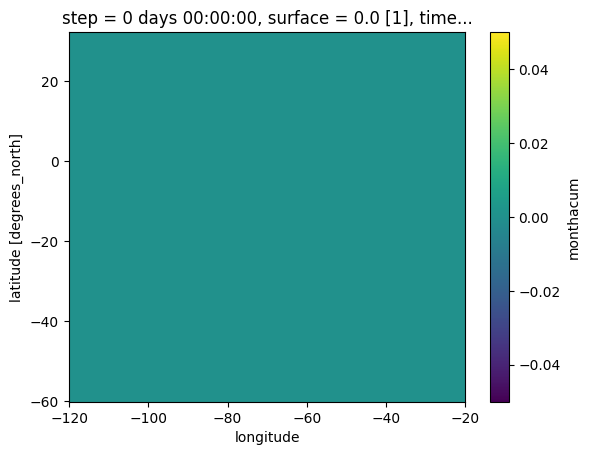

In [109]:
anomaly.plot()

<Axes: xlabel='Longitude (deg)', ylabel='Latitude (deg)'>

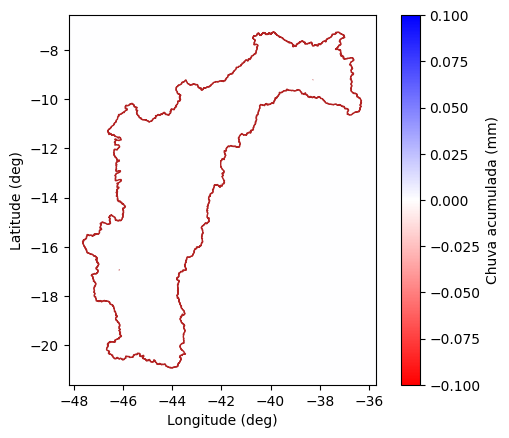

In [107]:
_,ax = plt.subplots()

RainReporter.plot_raster_shape(
    raster=anomaly,
    shp=shp,
    plt_ax=ax,
    cmap='bwr_r',
    # vmin=-400,
    # vmax=400
    diverging=True
)

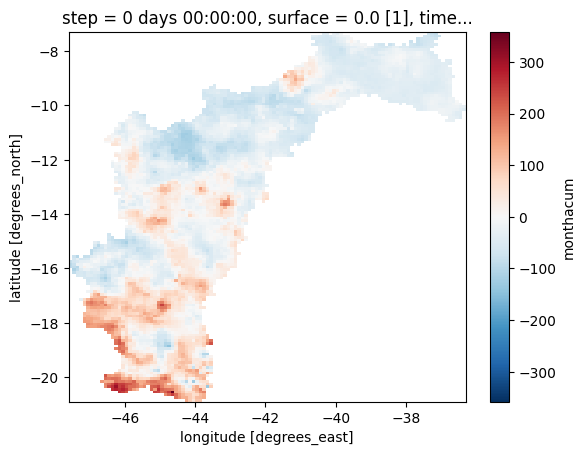

In [96]:
anomaly.rio.clip(shp.geometry).plot()

In [2]:
from dateutil.relativedelta import relativedelta

In [3]:
from datetime import datetime

In [4]:
now = datetime.now()

In [16]:
now = now + relativedelta(day=1, hour=0, minute=0, second=0, microsecond=0)

In [11]:
from dateutil.parser import parse

In [14]:
date = parse('2023-04') + relativedelta(day=1)

In [17]:
date, now

(datetime.datetime(2023, 4, 1, 0, 0), datetime.datetime(2023, 4, 1, 0, 0))

In [18]:
date == now

True

In [10]:
dateutil.parser

<module 'dateutil.parser' from '/usr/local/lib/python3.10/dist-packages/dateutil/parser/__init__.py'>

In [47]:
date = lta.time[-1].values#.astype(datetime.datetime)

In [1]:
pd.to_datetime(date).month

NameError: name 'pd' is not defined

In [39]:
np.datetime64('2023-04-10')

numpy.datetime64('2023-04-10')

In [43]:
datetime.datetime(date.astype(datetime.datetime))

OverflowError: signed integer is greater than maximum

In [44]:
import numpy as np
import datetime

# create a numpy datetime object
np_dt = np.datetime64('2022-03-01T12:00:00.000000000')

# convert numpy datetime object to datetime object
dt = np_dt.astype(datetime.datetime)

# get the month of the datetime object
month = dt.month

# print the result
print(month)


AttributeError: 'int' object has no attribute 'month'

In [46]:
datetime.datetime.fromtimestamp(dt)


OSError: [Errno 75] Value too large for defined data type

In [45]:
dt

1646136000000000000

In [25]:
cube.time[-1]

<xarray.DataArray 'time' ()>
array('2023-03-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step         timedelta64[ns] 00:00:00
    surface      float64 0.0
    time         datetime64[ns] 2023-03-01T12:00:00
    spatial_ref  int64 0

## Create the Animation Cube

In [17]:
files = downloader.get_range('20230101', '2023-12', local_folder='../tmp', datatype=INPETypes.MONTHLY_ACUM)
cube = downloader.create_cube(files)[INPETypes.MONTHLY_ACUM.value]

In [18]:
# set the limits for the colorbar
vmin = 0
vmax = float(cube.max()) * 0.7
vmax=600

In [17]:
import io
from PIL import Image

file_name = 'rain_animation.gif'

# create a figure to be used as a canvas
fig = plt.figure()

# create a list to store the temporary in-memory files
files = []
for time in cube.time.data:
    plt_ax = fig.add_subplot()
    cube.sel(time=time).plot(ax=plt_ax, vmin=vmin, vmax=vmax)

    # Create a temporary file
    file_like = io.BytesIO()

    fig.savefig(file_like)
    files.append(file_like)
    fig.clear()

# Now, with the files created in memory, let's use PIL to save the GIF
images = []
for file in files:
    img = Image.open(file)
    images.append(img)

images[0].save(
    file_name,
    save_all=True,
    append_images=images[1:],
    duration=300,
    loop=1,
)


<Figure size 640x480 with 0 Axes>

In [2]:
7*3.5*1.5

36.75

In [3]:
36*6

216

In [19]:
cube['time']

<xarray.DataArray 'time' (time: 12)>
array(['2022-01-01T12:00:00.000000000', '2022-02-01T12:00:00.000000000',
       '2022-03-01T12:00:00.000000000', '2022-04-01T12:00:00.000000000',
       '2022-05-01T12:00:00.000000000', '2022-06-01T12:00:00.000000000',
       '2022-07-01T12:00:00.000000000', '2022-08-01T12:00:00.000000000',
       '2022-09-01T12:00:00.000000000', '2022-10-01T12:00:00.000000000',
       '2022-11-01T12:00:00.000000000', '2022-12-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01T12:00:00 ... 2022-12-01T12:...
    spatial_ref  int64 0
Attributes:
    long_name:  Time

In [20]:
cube.sel({'time': '2022-01-01T12:00:00.000000000' })

<xarray.DataArray 'precacum' (latitude: 924, longitude: 1001)>
array([[111.87216 , 131.85228 , 131.57103 , ...,  45.678978,  43.309658,
         42.72443 ],
       [133.94318 , 133.3892  , 133.2358  , ...,  43.301136,  41.795456,
         40.83807 ],
       [134.23296 , 134.65909 , 133.2642  , ...,  42.127842,  41.576706,
         40.451706],
       ...,
       [ 37.897728,  37.951706,  36.892044, ...,  40.159092,  41.173294,
         42.778408],
       [ 37.954544,  37.03125 ,  35.74432 , ...,  40.909092,  41.789772,
         41.451706],
       [ 37.454544,  36.43182 ,  36.83807 , ...,  40.835228,  42.508522,
         41.65057 ]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 -120.0 -119.9 -119.8 ... -20.15 -20.05
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
    time         datetime64[ns] 2022-01-01T12:00:00
    spatial_ref  int64 0